En este notebook aplicamos **SHAP**

# Libraries

In [1]:
# random
import random as rd

In [2]:
# Data management
try:
    import pandas as pd
except:
    %pip install pandas --quiet
    import pandas as pd

try:
    import numpy as np
except:
    %pip install numpy --quiet
    import numpy as np

import os

In [3]:
# Plots
try:
    import matplotlib.pyplot as plt
except:
    %pip install matplotlib --quiet
    import matplotlib.pyplot as plt

try:
    import seaborn as sns
except:
    %pip install seaborn --quiet
    import seaborn as sns
sns.set_style("white")

/home/alvaronl/miniconda3/envs/jisbd/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [4]:
# Warnings
try:
    import warnings as ws
except:
    %pip install warnings --quiet
    import warnings as ws
ws.filterwarnings("ignore")

In [5]:
# ML
try:
    import xgboost
except:
    %pip install xgboost --quiet
    import xgboost

from sklearn import datasets, ensemble, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.utils.multiclass import unique_labels
from statistics import mean

In [6]:
from xgboost import XGBClassifier

In [7]:
# XAI
# SHAP
try:
  import shap
except:
  %pip install shap --quiet
  import shap
# LIME
try:
  from lime import lime_tabular
except:
  %pip install lime
  from lime import lime_tabular

In [8]:
#  para construir gráficas y realizar análisis exploratorio de los datos
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm

# Functions

In [9]:
# función auxiliar que evalúa los resultados de una clasificación
def evaluate_model(y_true, y_pred, y_score=None, pos_label='positive'):
  print('==== Sumario de la clasificación ==== ')
  print(classification_report(y_true, y_pred))

  print('Accuracy -> {:.2%}\n'.format(accuracy_score(y_true, y_pred)))

def evaluate_model_confusion_matrix(y_true, y_pred, y_score=None, pos_label='positive'): 
  # graficar matriz de confusión
  display_labels = sorted(unique_labels(y_true, y_pred), reverse=True)
  cm = confusion_matrix(y_true, y_pred, labels=display_labels)

  z = cm[::-1]
  x = display_labels
  y =  x[::-1].copy()
  z_text = [[str(y) for y in x] for x in z]

  fig_cm = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

  fig_cm.update_layout(
      height=400, width=400,
      showlegend=True,
      margin={'t':150, 'l':0},
      title={'text' : 'Matriz de Confusión', 'x':0.5, 'xanchor': 'center'},
      xaxis = {'title_text':'Valor Real', 'tickangle':45, 'side':'top'},
      yaxis = {'title_text':'Valor Predicho', 'tickmode':'linear'},
  )
  fig_cm.show()


  # curva roc (definido para clasificación binaria)
#   fig_roc = None
#   if y_score is not None:
#     fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
#     fig_roc = px.area(
#         x=fpr, y=tpr,
#         title={'text' : f'Curva ROC (AUC={auc(fpr, tpr):.4f})', 'x':0.5, 'xanchor': 'center'},
#         labels=dict(x='Ratio Falsos Positivos', y='Ratio Verdaderos Positivos'),
#         width=400, height=400
#     )
#     fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

#     fig_roc.update_yaxes(scaleanchor="x", scaleratio=1)
#     fig_roc.update_xaxes(constrain='domain')
    
#     fig_roc.show()

In [10]:
def get_comb_aux(elem, list_elems):
    return [] if len(list_elems)==0 else [elem+"_"+list_elems[0]] + get_comb_aux(elem, list_elems[1:len(list_elems)])
    
def get_combinations(list_elems):
    if len(list_elems) <= 1:
        return []
    elif len(list_elems) == 2:
        return [list_elems[0] + "_" + list_elems[1]]
    else:
        return get_comb_aux(list_elems[0], list_elems[1:len(list_elems)]) + get_combinations(list_elems[1:len(list_elems)])

In [11]:
# def eval_fairness(y_pred_a, y_true_a, y_pred_b, y_true_b):
#     data = {}
#     # False Positive Rates FPR = FP / (FP + TN)
#     data['FPR_b'] = np.sum((y_pred_a == 1) * (y_true_a == 0)) / np.sum(y_true_a == 0) #fpr_black
#     data['FPR_w'] = np.sum((y_pred_b == 1) * (y_true_b == 0)) / np.sum(y_true_b == 0) #fpr_white
#     # True positive rates TPR = TP / (TP + FN)
#     data['TPR_b'] = np.sum((y_pred_a == 1)*(y_true_a == 1)) / np.sum(y_true_a == 1) #tpr_black
#     data['TPR_w'] = np.sum((y_pred_b == 1)*(y_true_b == 1)) / np.sum(y_true_b == 1) #tpr_white
#     data['Eq. Oportunity'] = abs(data['TPR_w']-data['TPR_b'])
#     data['Pred. Equality'] = abs(data['FPR_w']-data['FPR_b'])
#     data['Eq. odds'] = abs(data['TPR_w']-data['TPR_b']) + abs(data['FPR_w']-data['FPR_b'])    
#     return data 

In [12]:
def eval_fairness_rates(FPR_a, FPR_b, TPR_a, TPR_b):
    data = {}
    data['Eq.Oportunity'] = abs(TPR_a-TPR_b)
    data['Pred.Equality'] = abs(FPR_a-FPR_b)
    data['Eq.odds'] = data['Eq.Oportunity'] + data['Pred.Equality']
    return data 

In [13]:
def factorial(n): 
    return 1 if (n==1 or n==0) else n * factorial(n - 1)

# Data

In [14]:
# Load processed
current_path = os.getcwd()
dst_path = os.path.join(current_path, "data_dst")
file_name = "processed_compas.csv"
file = os.path.join(dst_path, file_name)
df = pd.read_csv(file)

In [15]:
df.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,c_charge_degree,is_recid,is_violent_recid,decile_score.1,v_decile_score,two_year_recid,days_custody,days_c_jail,days_r_jail
0,0,69,0,0,1,0,0,0,1.0,1,0,0,1,1,0,8,2,0
1,0,34,1,0,3,0,0,0,1.0,1,1,1,3,1,1,11,11,0
2,0,24,1,0,4,0,1,4,1.0,1,1,0,4,3,1,1,2,1
3,0,23,1,0,8,1,0,1,1.0,1,0,0,8,6,0,0,0,0
4,0,43,0,0,1,0,0,2,76.0,1,0,0,1,1,0,0,0,0


In [16]:
rs = np.random.RandomState(0)
corr = df.corr()
corr.style.background_gradient(cmap="coolwarm").format("{:.2f}")

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,c_charge_degree,is_recid,is_violent_recid,decile_score.1,v_decile_score,two_year_recid,days_custody,days_c_jail,days_r_jail
sex,1.00,0.00,0.02,-0.06,-0.06,-0.05,-0.06,-0.12,0.00,-0.05,-0.10,-0.06,-0.06,-0.12,-0.09,-0.04,-0.06,-0.06
age,0.00,1.00,0.12,-0.07,-0.39,-0.12,-0.16,0.14,0.09,-0.09,-0.20,-0.10,-0.39,-0.58,-0.19,-0.01,0.01,-0.05
race,0.02,0.12,1.00,-0.05,-0.17,-0.07,-0.03,-0.12,-0.02,-0.07,-0.09,-0.04,-0.17,-0.18,-0.08,-0.04,-0.02,-0.05
juv_fel_count,-0.06,-0.07,-0.05,1.00,0.18,0.09,0.05,0.18,0.00,0.05,0.09,0.06,0.18,0.17,0.09,0.06,0.06,0.11
decile_score,-0.06,-0.39,-0.17,0.18,1.00,0.22,0.18,0.44,0.03,0.18,0.35,0.17,1.00,0.78,0.35,0.16,0.21,0.19
juv_misd_count,-0.05,-0.12,-0.07,0.09,0.22,1.00,0.27,0.24,0.01,0.03,0.11,0.09,0.22,0.21,0.11,0.03,0.04,0.03
juv_other_count,-0.06,-0.16,-0.03,0.05,0.18,0.27,1.00,0.10,0.00,0.03,0.11,0.05,0.18,0.20,0.11,0.10,0.04,0.02
priors_count,-0.12,0.14,-0.12,0.18,0.44,0.24,0.10,1.00,0.01,0.14,0.28,0.09,0.44,0.21,0.28,0.13,0.20,0.14
c_days_from_compas,0.00,0.09,-0.02,0.00,0.03,0.01,0.00,0.01,1.00,-0.05,-0.07,-0.01,0.03,-0.01,-0.07,0.05,0.02,-0.01
c_charge_degree,-0.05,-0.09,-0.07,0.05,0.18,0.03,0.03,0.14,-0.05,1.00,0.10,-0.01,0.18,0.14,0.11,0.08,0.12,0.09


In [17]:
df_backup = df.copy()

## Split data

In [18]:
# variables salida
# 1. v_decile_sore
# y1 = df["v_decile_score"]
# df = df.drop(["v_decile_score"], axis=1)
# df = df.drop(["decile_score"], axis=1)
# df = df.drop(["decile_score.1"], axis=1)
# 2. v_decile_text
# y2 = df["v_score_text"]
# df = df.drop(["v_score_text"], axis=1)
# df = df.drop(["score_text"], axis=1)
# 3. two_year_recid
y3 = df["two_year_recid"]
df = df.drop(["two_year_recid"], axis=1)
# 4. is_recid
# y3 = df["is_recid"]
# df = df.drop(["is_recid"], axis=1)

In [19]:
x_data = df.drop(["is_recid"], axis=1)
y_data = df["is_recid"]

# Experiment 1: SHAP

## xgboost

In [20]:
# Split data
x1_train, x1_test, y1_train, y1_test = model_selection.train_test_split(x_data, y_data, random_state=0)
# Model
# m1 = xgboost.XGBRegressor().fit(x1_train, y1_train)
m1 = XGBClassifier().fit(x1_train, y1_train)
# m1 = xgboost.XGBRegressor(enable_categorical=True).fit(x1_train, y1_train)

In [21]:
m1.score(x1_train,y1_train)

0.9482758620689655

In [22]:
y_pred = m1.predict(x1_test)
# y_pred = [0 if y_i < 0.5 else 1 for y_i in y_pred] # para regresores

In [23]:
evaluate_model(y1_test, y_pred)

==== Sumario de la clasificación ==== 
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       949
           1       0.92      0.79      0.85       849

    accuracy                           0.87      1798
   macro avg       0.88      0.86      0.87      1798
weighted avg       0.87      0.87      0.87      1798

Accuracy -> 86.76%



In [24]:
cm = confusion_matrix(y1_test, y_pred)
cm

array([[890,  59],
       [179, 670]])

In [25]:
# evaluate_model_confusion_matrix(y1_test, y_pred)

In [26]:
# new_row_tmp = {'race': race_tmp, 'TP':cm_tmp[1,1], 'TN':cm_tmp[0,0], 'FP':cm_tmp[1,0], 'FN':cm_tmp[0,1], 'FPR': FPR, 'TPR': TPR}

In [27]:
TN = cm[0,0]
print(f"There are {TN} True Negatives")
TP = cm[1,1]
print(f"There are {TP} True Positives")
FN = cm[0,1]
print(f"There are {FN} False Negatives")
FP = cm[1,0]
print(f"There are {FP} False Positives")

There are 890 True Negatives
There are 670 True Positives
There are 59 False Negatives
There are 179 False Positives


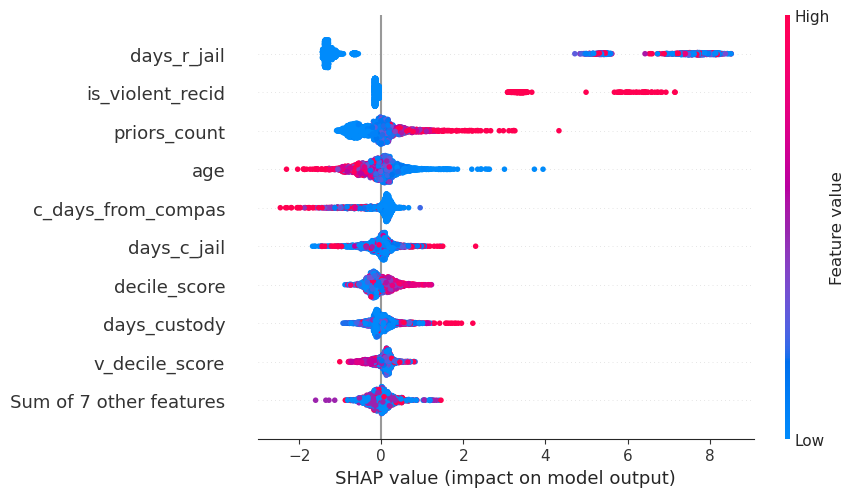

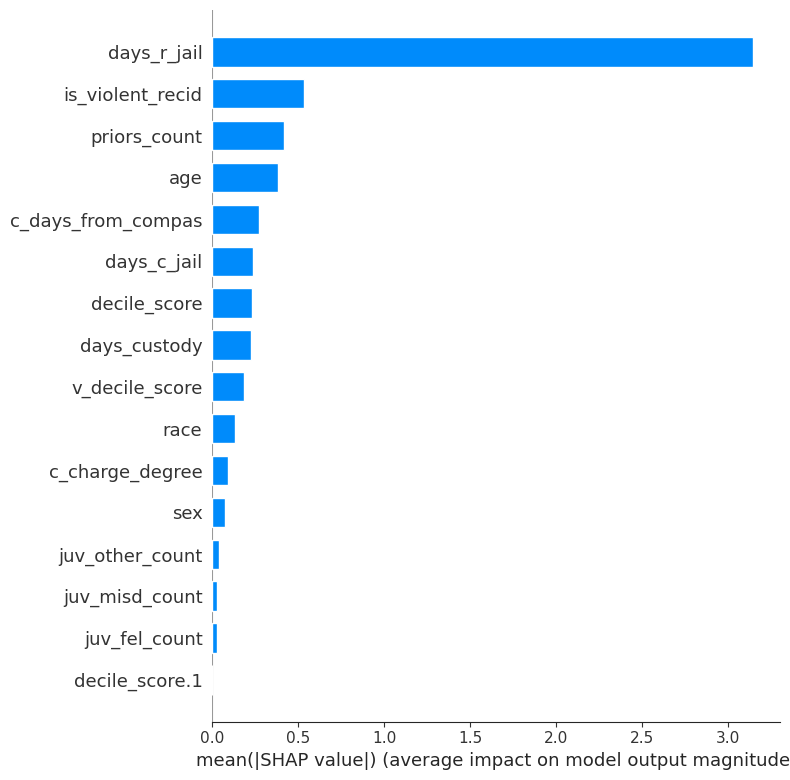

In [28]:
# SHAP
explainer_1 = shap.Explainer(m1)
shap_values_1 = explainer_1(x1_test)
shap.plots.beeswarm(shap_values_1, max_display=10) #summary_plot
shap.summary_plot(shap_values_1, x1_train, plot_type="bar")

# Fairness

* First, we obtain the TN, TP, FN and FP for each class.
* Second, we create a dataframe with these values.
* Third, we obtan the fairness metrics for each pair.
* Finally, we save them in a new dataframe to show the fairness in the df.


In [29]:
# df.loc[df["race"] == "Other", "race"] = 0
# df.loc[df["race"] == "African-American", "race"] = 1
# df.loc[df["race"] == "Caucasian", "race"] = 2
# df.loc[df["race"] == "Hispanic", "race"] = 3
# df.loc[df["race"] == "Native American", "race"] = 4
# df.loc[df["race"] == "Asian", "race"] = 5

# df.loc[df["sex"] == "Male", "sex"] = 0
# df.loc[df["sex"] == "Female", "sex"] = 1

## Race

In [30]:
# dict
dict_df_race = {0: "other", 1: "african-american", 2: "caucasican", 3: "hispanic", 4: "native-american" , 5: "asian"}
list_races = list(dict_df_race.values())
# df
df_race_other = df[df["race"]==0].copy()
df_race_african_american = df[df["race"]==1].copy()
df_race_caucasican = df[df["race"]==2].copy()
df_race_hispanic = df[df["race"]==3].copy()
df_race_native_american = df[df["race"]==4].copy()
df_race_asian = df[df["race"]==5].copy()
# list of df
list_df = [df_race_other, df_race_african_american, df_race_caucasican,
df_race_hispanic, df_race_native_american, df_race_asian]

In [31]:
# False Positive Rates FPR = FP / (FP + TN)
# True positive rates TPR = TP / (TP + FN)

In [33]:
def get_cm_metrics(list_df, dict_df_race = dict_df_race):
    df_cm_metrics = pd.DataFrame()
    for i in range(len(list_df)):
        race_tmp = dict_df_race[i]
        print(f"The df with id {i} is for the race {race_tmp}")
        df_tmp = list_df[i]
        # split data
        x_data_tmp = df_tmp.drop(["is_recid"], axis=1)
        y_data_tmp = df_tmp["is_recid"]
        x_train_tmp, x_test_tmp, y_train_tmp, y_test_tmp = model_selection.train_test_split(x_data_tmp, y_data_tmp, random_state=0)
        # model
        m_tmp = XGBClassifier().fit(x_train_tmp, y_train_tmp)
        m_tmp.score(x_train_tmp,y_train_tmp)
        # pred and confusion matrix
        y_pred_tmp = np.array(m_tmp.predict(x_test_tmp))
        # y_pred_tmp = np.array([0 if y_i < 0.5 else 1 for y_i in y_pred_tmp]) # para regresores
        cm_tmp = confusion_matrix(y_pred_tmp, y_test_tmp)
        # Rates
        # y_true_tmp = y_test_tmp
        # y_true_tmp = np.array([0 if y_i < 0.5 else 1 for y_i in y_test_tmp]) # para regresores
        # fpr_black = np.sum((y_pred_black == 1) * (y_true_black == 0)) / np.sum(y_true_black == 0)
        FPR_tmp = np.sum((y_pred_tmp == 1) * (y_test_tmp == 0)) / np.sum(y_test_tmp == 0)
        # tpr_black = np.sum((y_pred_black == 1)*(y_true_black == 1)) / np.sum(y_true_black == 1)
        TPR_tmp = np.sum((y_pred_tmp == 1) * (y_test_tmp == 1)) / np.sum(y_test_tmp == 1)
        # Add row to df
        # new_row_tmp = {'race': race_tmp,'FPR': FPR, 'TPR': TPR}
        new_row_tmp = {'race': race_tmp, 'TP':cm_tmp[1,1], 'TN':cm_tmp[0,0], 'FP':cm_tmp[1,0], 'FN':cm_tmp[0,1], 
        'FPR': FPR_tmp, 'FP/(FP+TN)': cm_tmp[1,0]/(cm_tmp[1,0]+cm_tmp[0,0]),
        'TPR': TPR_tmp, 'TP/(TP+FN)': cm_tmp[1,1]/(cm_tmp[1,1]+cm_tmp[0,1])}
        # df_cm_metrics = df_cm_metrics.append(new_row_tmp, ignore_index=True)
        df_cm_metrics = pd.concat(
            [df_cm_metrics, pd.DataFrame([new_row_tmp])],
            ignore_index=True
        )
    return df_cm_metrics

df_cm_metrics = get_cm_metrics(list_df)
# ws.filterwarnings("ignore")

The df with id 0 is for the race other
The df with id 1 is for the race african-american
The df with id 2 is for the race caucasican
The df with id 3 is for the race hispanic
The df with id 4 is for the race native-american
The df with id 5 is for the race asian


In [34]:
df_cm_metrics

,race,TP,TN,FP,FN,FPR,FP/(FP+TN),TPR,TP/(TP+FN)
0,other,24,50,9,11,0.152542,0.152542,0.685714,0.685714
1,african-american,386,383,59,94,0.133484,0.133484,0.804167,0.804167
2,caucasican,202,336,19,56,0.053521,0.053521,0.782946,0.782946
3,hispanic,39,87,9,23,0.093750,0.093750,0.629032,0.629032
4,native-american,1,3,0,1,0.000000,0.000000,0.500000,0.500000
5,asian,2,5,0,1,0.000000,0.000000,0.666667,0.666667


In [36]:
# # Al ser una combinación sin repetición hacemos
# # factorial de n (6) dividido por el factorial de r (2) y el de n-r (4)
# n = len(df_cm_metrics)
# r = 2
# n_iterations = int(factorial(n)/(factorial(r)*factorial(n-r)))
# df
df_fairness = pd.DataFrame()
data_fairness = {}
list_combs = get_combinations(list_races)
for comb in list_combs:
    race_a_tmp, race_b_tmp = comb.split("_")
    # print(f"#### {race_a_tmp} and {race_b_tmp} ####")
    FPR_a_tmp = list(df_cm_metrics.loc[df_cm_metrics["race"]==race_a_tmp,"FPR"])[0]
    TPR_a_tmp = list(df_cm_metrics.loc[df_cm_metrics["race"]==race_a_tmp,"TPR"])[0]
    FPR_b_tmp = list(df_cm_metrics.loc[df_cm_metrics["race"]==race_b_tmp,"FPR"])[0]
    TPR_b_tmp = list(df_cm_metrics.loc[df_cm_metrics["race"]==race_b_tmp,"TPR"])[0]
    # data_fairness = list(eval_fairness_rates(FPR_a_tmp, FPR_b_tmp, TPR_a_tmp, TPR_b_tmp)) + data_fairness
    data_fairness[comb] = eval_fairness_rates(FPR_a_tmp, FPR_b_tmp, TPR_a_tmp, TPR_b_tmp)
    new_row_tmp = {'race_comb': comb, 'Eq.Oportunity': data_fairness[comb]['Eq.Oportunity'], 'Pred.Equality':data_fairness[comb]['Pred.Equality'], 'Eq.odds':data_fairness[comb]['Eq.odds']}
    # df_fairness = df_fairness.append(new_row_tmp, ignore_index=True)
    df_fairness = pd.concat(
    [df_fairness, pd.DataFrame([new_row_tmp])],
    ignore_index=True
    )

In [37]:
df_fairness.style.highlight_max(color='red')

,race_comb,Eq.Oportunity,Pred.Equality,Eq.odds
0,other_african-american,0.118452,0.019058,0.137511
1,other_caucasican,0.097231,0.099021,0.196253
2,other_hispanic,0.056682,0.058792,0.115474
3,other_native-american,0.185714,0.152542,0.338257
4,other_asian,0.019048,0.152542,0.171590
5,african-american_caucasican,0.021221,0.079963,0.101184
6,african-american_hispanic,0.175134,0.039734,0.214869
7,african-american_native-american,0.304167,0.133484,0.437651
8,african-american_asian,0.137500,0.133484,0.270984
9,caucasican_hispanic,0.153913,0.040229,0.194142


## Sex

In [ ]:
# Evaluate fairness metrics
# data = eval_fairness(y_pred, y1_test, black_mask, white_mask)

# More inside

We analyze the most unfair class dataframe.

### Caucasican + Native American

**important**: It must be automatizated, with the index ot he max value in the df.

In [38]:
n_caucasican = len(df_race_caucasican)
print(f"rows of caucasican {n_caucasican}")
n_native_american = len(df_race_native_american)
print(f"rows of native american {n_native_american}")

rows of caucasican 2449
rows of native american 17


## Experiment 1: Look for variables

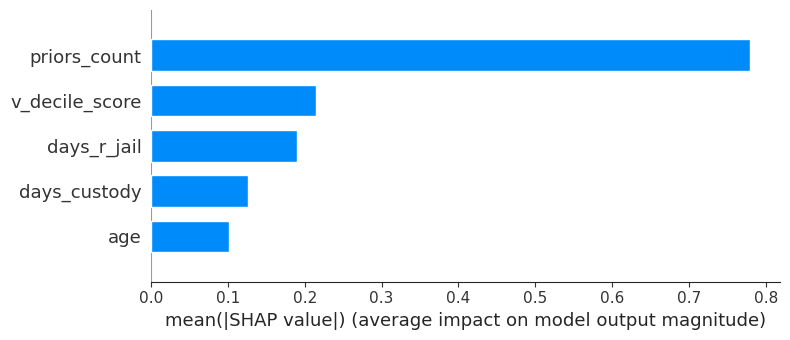

In [39]:
# SHAP native american
# Split data
x_native_american_train, x_native_american_test, y_native_american_train, y_native_american_test = model_selection.train_test_split(df_race_native_american.drop(["is_recid"], axis=1), df_race_native_american["is_recid"], random_state=0)
# Model
m_native_american = XGBClassifier().fit(x_native_american_train, y_native_american_train)
explainer_native_american = shap.Explainer(m_native_american)
shap_values_native_american = explainer_native_american(x_native_american_test)
# shap.plots.beeswarm(shap_values_native_american, max_display=10)
shap.summary_plot(shap_values_native_american, x_native_american_train, plot_type="bar", max_display=5)

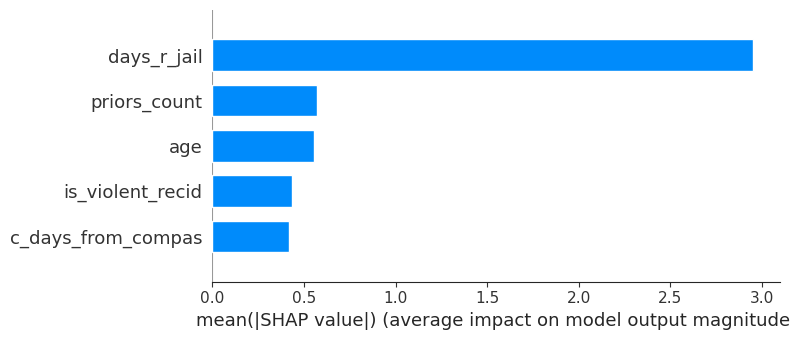

In [40]:
# SHAP caucasican
# Split data
x_caucasican_train, x_caucasican_test, y_caucasican_train, y_caucasican_test = model_selection.train_test_split(df_race_caucasican.drop(["is_recid"], axis=1), df_race_caucasican["is_recid"], random_state=0)
# Model
m_caucasican = XGBClassifier().fit(x_caucasican_train, y_caucasican_train)
explainer_caucasican = shap.Explainer(m_caucasican)
shap_values_caucasican = explainer_caucasican(x_caucasican_test)
# shap.plots.beeswarm(shap_values_caucasican, max_display=10)
shap.summary_plot(shap_values_caucasican, x_caucasican_train, plot_type="bar", max_display=5)
# Tiene sentido que la race tenga más peso que antes al ser un valor categórico entre dos clasees en lugar de 6

## Experiment 2: Rebalance

### 2.1 Smote-> rejected

In [ ]:
# # No rebalance
# def get_eq_odss(df_cm, race_a, race_b):
#     FPR_a = list(df_cm.loc[df_cm["race"]==race_a,"FPR"])[0]
#     TPR_a = list(df_cm.loc[df_cm["race"]==race_a,"TPR"])[0]
#     FPR_b = list(df_cm.loc[df_cm["race"]==race_b,"FPR"])[0]
#     TPR_b = list(df_cm.loc[df_cm["race"]==race_b,"TPR"])[0]
#     data_a_b = eval_fairness_rates(FPR_a, FPR_b, TPR_a, TPR_b)
#     return round(data_a_b['Eq.odds'], 3)
# get_eq_odss(df_cm_metrics, "native_american", "caucasican")


In [ ]:
# from imblearn.over_sampling import SMOTE, RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# dict_df_race = {0: "other", 1: "african-american", 2: "caucasican", 3: "hispanic", 4: "native-american" , 5: "asian"}

In [ ]:
# df_caucasican_native_american = pd.concat([df_race_caucasican, df_race_native_american])
# len(df_caucasican_native_american)

In [ ]:
# len(df_caucasican_native_american.loc[df_caucasican_native_american["race"]==2,])

In [ ]:
# len(df_caucasican_native_american.loc[df_caucasican_native_american["race"]==4,])

In [ ]:
# # the input is the df with the two (or more) classes (races)
# def get_cm_smote_rebalance(df_smote):
#     races_ini = df_smote["race"].unique()
#     print(f"races at the begining {races_ini}")
#     oversample = SMOTE()
#     x_data = df_smote.drop(["is_recid"], axis=1)
#     y_data = df_smote["is_recid"]
#     x_data, y_data = oversample.fit_resample(x_data, y_data)
#     df_smote_tmp = pd.DataFrame(x_data)
#     df_smote_tmp["is_recid"] = y_data
#     races_end = df_smote_tmp["race"].unique()
#     print(f"races at the ending {races_end}")
#     # list_df_smote_tmp = [df_smote_tmp.loc[df_smote_tmp["race"]==race_i, ] for race_i in df_smote_tmp["race"].unique()]
#     # cm_smote = get_cm_metrics(list_df_smote_tmp)
#     return df_smote_tmp
    

In [ ]:
# df_balanced = get_cm_smote_rebalance(df_caucasican_native_american)

In [ ]:
# df_balanced.head()

In [ ]:
# df_balanced["race"].unique()

In [ ]:
# len(df_balanced)

In [ ]:
# len(df_balanced.loc[df_balanced["race"]==4,])

In [ ]:
# len(df_balanced.loc[df_balanced["race"]==2,])

In [ ]:
# len(df_balanced.loc[df_balanced["race"]==3,])

### 2.2 -> COrrelation Combination blOckS (COCOS)

1. Sea cual sea necesito que sea **con repetición**, para poder llenar con datos muchas veces y no sólo unas pocas filas.

2. La división por bloques puede precisar de un estudio del dominio.

3. El máximo posible de bloques es igual al número de columnas, es decir, a la dimensionalidad.

4. Ejemplo: en Ajedrez, título va ligado al ELO (rating).


**tip**: Observar correlaciones.

A mayor cantidad de bloques más difícil será mantener el "orden actual", aunque eso no es necesariamence malo pues existe una injusticia. A mayor número de bloques habrá un mejor aumentado de datos debido a tener más posibles combinaciones.

Qs: ¿Máximo de columnas por bloque? ¿Puede haber dos o más bloques con dicho número?

In [ ]:
df_race_native_american["race"].unique()

array([4], dtype=int64)

In [ ]:
df_race_native_american_pre_balance = df_race_native_american.drop(["race"], axis=1).copy()

In [ ]:
# native_american
nrows_native_american = len(df_race_native_american_pre_balance)
print(f"there are {nrows_native_american} rows for native_american race")
# caucasican
nrows_caucasican = len(df_race_caucasican)
print(f"there are {len(df_race_caucasican)} rows for caucasican race")

there are 17 rows for native_american race
there are 2449 rows for caucasican race


In [ ]:
df_race_native_american_pre_balance.columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_days_from_compas', 'c_charge_degree', 'is_recid',
       'is_violent_recid', 'days_custody', 'days_c_jail', 'days_r_jail'],
      dtype='object')

In [ ]:
df_race_native_american_pre_balance

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,c_charge_degree,is_recid,is_violent_recid,days_custody,days_c_jail,days_r_jail
458,1,34,0,0,0,4,152.0,1,1,0,17,98,1
760,0,27,0,0,0,3,0.0,0,0,0,2,2,0
880,0,38,0,0,1,25,172.0,0,1,0,9,9,6
1164,0,25,0,0,0,7,0.0,1,1,1,7,2,0
1178,0,42,0,0,0,0,1.0,0,0,0,4,4,0
1471,0,28,0,0,0,2,1.0,1,0,0,50,50,0
1704,1,45,0,0,0,1,147.0,0,0,0,0,0,0
1859,0,29,0,0,0,1,187.0,1,0,0,34,34,0
1952,0,37,0,0,0,0,1.0,1,0,0,2,2,0
2123,1,45,0,0,0,15,1.0,1,1,0,143,2,0


In [ ]:
rs = np.random.RandomState(0)
corr = df_race_native_american_pre_balance.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,c_charge_degree,is_recid,is_violent_recid,days_custody,days_c_jail,days_r_jail
sex,1.00,0.39,-0.17,-0.14,-0.20,-0.01,0.16,0.18,0.18,-0.31,0.01,-0.04,0.27
age,0.39,1.00,0.40,-0.41,-0.18,0.39,0.04,-0.16,-0.19,-0.51,-0.23,-0.27,-0.23
juv_fel_count,-0.17,0.40,1.00,-0.08,-0.11,0.53,-0.14,0.13,0.26,-0.03,-0.13,-0.08,-0.04
juv_misd_count,-0.14,-0.41,-0.08,1.00,-0.09,-0.18,-0.17,0.21,0.21,0.45,0.26,-0.10,0.47
juv_other_count,-0.20,-0.18,-0.11,-0.09,1.00,0.30,0.16,-0.44,0.31,-0.20,-0.20,-0.15,-0.13
priors_count,-0.01,0.39,0.53,-0.18,0.30,1.00,0.21,0.07,0.56,0.05,0.20,0.10,-0.08
c_days_from_compas,0.16,0.04,-0.14,-0.17,0.16,0.21,1.00,-0.08,0.07,0.08,0.20,0.50,-0.19
c_charge_degree,0.18,-0.16,0.13,0.21,-0.44,0.07,-0.08,1.00,0.27,0.18,0.38,0.28,0.20
is_recid,0.18,-0.19,0.26,0.21,0.31,0.56,0.07,0.27,1.00,0.46,0.35,0.24,0.36
is_violent_recid,-0.31,-0.51,-0.03,0.45,-0.20,0.05,0.08,0.18,0.46,1.00,0.54,0.43,0.24


In [ ]:
block_1 = ["sex"]
block_2 = ["age"] # está correlada con age, pero prefiero alejarlas por su significado semántico
block_3 = ["days_custody","days_c_jail", "c_days_from_compas"]
# race does not matter in this case since I will operato with one-class (race) df
block_4 = ["is_recid", "priors_count", "juv_fel_count", "is_violent_recid", "juv_other_count"]
block_5 = ["days_r_jail", "juv_misd_count"]
block_6 = ["c_charge_degree"]
blocks = [block_1, block_2, block_3, block_4, block_5, block_6] 

len(block_1) + len(block_2) + len(block_3) + len(block_4) + len(block_5) + len(block_6) == len(df_race_native_american_pre_balance.columns)

True

In [ ]:
df_race_native_american_pre_balance[block_3]

,days_custody,days_c_jail,c_days_from_compas
458,17,98,152.0
760,2,2,0.0
880,9,9,172.0
1164,7,2,0.0
1178,4,4,1.0
1471,50,50,1.0
1704,0,0,147.0
1859,34,34,187.0
1952,2,2,1.0
2123,143,2,1.0


In [ ]:
len(df_race_native_american_pre_balance[["c_days_from_compas","days_c_jail", "c_days_from_compas"]]) - df_race_native_american_pre_balance[["c_days_from_compas","days_c_jail", "c_days_from_compas"]].duplicated().sum()

13

In [ ]:
blocks

[['sex'],
 ['age'],
 ['days_custody', 'days_c_jail', 'c_days_from_compas'],
 ['is_recid',
  'priors_count',
  'juv_fel_count',
  'is_violent_recid',
  'juv_other_count'],
 ['days_r_jail', 'juv_misd_count'],
 ['c_charge_degree']]

In [ ]:
# def eq_size_df(df, tam, blocks):
#     # it = 0
#     df_tmp = df.copy()
#     df_tmp = df_tmp.reset_index()
#     # tam_0 = len(df_tmp)
#     while len(df_tmp) < tam:
#         # print(f"it {it+1}/{tam-tam_0+1}")
#         data_tmp = {}
#         ids_tmp = list(df_tmp.index)
#         # print(f"len(ids_tmp) = {len(ids_tmp)}")
#         # print(f"ids_tmp: {ids_tmp}")
#         for block in blocks:
#             # print(f"block: {block}")
#             pos_tmp = rd.randint(0, len(ids_tmp)-1)
#             # print(f"pos_tmp: {pos_tmp}")
#             id_tmp = ids_tmp[pos_tmp]
#             # print(f"id = {id_tmp}")
#             for column_tmp in block:
#                 # print(f"column: {column_tmp}")
#                 data_tmp[column_tmp] = df_tmp.iloc[id_tmp, ][column_tmp]
#         # new row
#         df_tmp = df_tmp.append(data_tmp, ignore_index=True)
#         # reset index
#         # df_tmp = df_tmp.reset_index()
#         # it+=1
#     return df_tmp

In [ ]:
# df_race_native_american_balanced = eq_size_df(df_race_native_american_pre_balance, len(df_race_caucasican), blocks)

In [ ]:
# len(df_race_native_american_balanced)

In [ ]:
# list(df_race_native_american_balanced.index)

In [ ]:
# print(df_race_native_american_balanced.duplicated().sum())  # Las borro? #print(df.drop_duplicates())

In [ ]:
# df_race_native_american_balanced["race"] = 4

In [ ]:
# df_race_native_american_balanced.head()

In [ ]:
# cm_balanced = get_cm_metrics([df_race_native_american_balanced, df_race_caucasican], {0: "native-american", 1: "caucasican"})

In [ ]:
# cm_balanced

In [ ]:
# df_fairness_balanced = pd.DataFrame()
# data_fairness_balanced = {}
# FPR_native_american = list(cm_balanced.loc[cm_balanced["race"]=="native-american","FPR"])[0]
# TPR_native_american = list(cm_balanced.loc[cm_balanced["race"]=="native-american","TPR"])[0]
# FPR_caucasican = list(cm_balanced.loc[cm_balanced["race"]=="caucasican","FPR"])[0]
# TPR_caucasican = list(cm_balanced.loc[cm_balanced["race"]=="caucasican","TPR"])[0]
# # data_fairness = list(eval_fairness_rates(FPR_a_tmp, FPR_b_tmp, TPR_a_tmp, TPR_b_tmp)) + data_fairness
# data_fairness_balanced = eval_fairness_rates(FPR_native_american, FPR_caucasican, TPR_native_american, TPR_caucasican)
# row = {'race_comb': "native-american_caucasican", 'Eq.Oportunity': data_fairness_balanced['Eq.Oportunity'], 'Pred.Equality':data_fairness_balanced['Pred.Equality'], 'Eq.odds':data_fairness_balanced['Eq.odds']}
# df_fairness_balanced = df_fairness_balanced.append(row, ignore_index=True)
# # df_fairness_balanced.style.highlight_max(color='red')

In [ ]:
# Nuevo, tras balancear
# df_fairness_balanced

In [ ]:
# Anterior
# df_fairness.style.highlight_max(color='red')

In [ ]:
# # caucasican
# shap.summary_plot(shap_values_caucasican, x_caucasican_train, plot_type="bar", max_display=5)
# # native-american
# shap.summary_plot(shap_values_native_american, x_native_american_train, plot_type="bar", max_display=5)

In [ ]:
# # balanced native american
# # Split data
# x_balanced_native_american_train, x_balanced_native_american_test, y_balanced_native_american_train, y_balanced_native_american_test = model_selection.train_test_split(df_race_native_american_balanced.drop(["is_recid"], axis=1), df_race_native_american_balanced["is_recid"], random_state=0)
# # Model
# m_balanced_native_american = XGBClassifier().fit(x_balanced_native_american_train, y_balanced_native_american_train)
# explainer_balanced_native_american = shap.Explainer(m_balanced_native_american)
# shap_values_balanced_native_american = explainer_balanced_native_american(x_balanced_native_american_test)
# # shap.plots.beeswarm(shap_values_balanced_native_american, max_display=10)
# shap.summary_plot(shap_values_balanced_native_american, x_balanced_native_american_train, plot_type="bar", max_display=5)


### Optimizamos el algoritmo minimizando los repetidos

In [ ]:
def different_rows_df(df):
    return len(df) - df.duplicated().sum()

def get_combinations_rows(df, blocks):
    n_combs = 1
    for block in blocks:
        n_combs = n_combs * different_rows_df(df[block])
    return n_combs

In [ ]:
get_combinations_rows(df_race_native_american_pre_balance, blocks)

88200

In [ ]:
#eq_size_df_optimized
# necesitamos un contador de ieteracioens para no sobrecargar la carga temporal 
def cocos(df, tam, blocks, maxit = 10000):
    it = 0
    df_tmp = df.copy()
    # duplicates management
    df_tmp = df_tmp.drop_duplicates()
    max_independet_rows = get_combinations_rows(df, blocks)
    diff_tam = tam - len(df)
    threshold = max_independet_rows if max_independet_rows < diff_tam else 0
    # reset index
    df_tmp = df_tmp.reset_index()
    while len(df_tmp) < tam:
        data_tmp = {}
        ids_tmp = list(df_tmp.index)
        for block in blocks:
            pos_tmp = rd.randint(0, len(ids_tmp)-1)
            id_tmp = ids_tmp[pos_tmp]
            for column_tmp in block:
                data_tmp[column_tmp] = df_tmp.iloc[id_tmp, ][column_tmp]
        # new row
        df_tmp = df_tmp.append(data_tmp, ignore_index=True)
        # duplicates
        # print(f"df.duplicated().sum() {df.duplicated().sum()}")
        # print(f"threshold {threshold}")
        if df_tmp.duplicated().sum()>threshold and it<maxit:
            df_tmp = df_tmp.drop_duplicates()
        it+=1
    return df_tmp

In [ ]:
df_cocos_native_americans = cocos(df_race_native_american_pre_balance, len(df_race_caucasican), blocks)

In [ ]:
len(df_race_caucasican)

2449

In [ ]:
len(df_cocos_native_americans)

2449

In [ ]:
df_cocos_native_americans.duplicated().sum() 

0

In [ ]:
df_cocos_native_americans["race"] = 4

### Justicia

In [ ]:
cm_cocos = get_cm_metrics([df_cocos_native_americans, df_race_caucasican], {0: "native-american", 1: "caucasican"})

The df with id 0 is for the race native-american
[08:26:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The df with id 1 is for the race caucasican
[08:26:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
df_fairness_cocos = pd.DataFrame()
data_fairness_cocos = {}
FPR_native_american_cocos = list(cm_cocos.loc[cm_cocos["race"]=="native-american","FPR"])[0]
TPR_native_american_cocos = list(cm_cocos.loc[cm_cocos["race"]=="native-american","TPR"])[0]
FPR_caucasican_cocos = list(cm_cocos.loc[cm_cocos["race"]=="caucasican","FPR"])[0]
TPR_caucasican_cocos = list(cm_cocos.loc[cm_cocos["race"]=="caucasican","TPR"])[0]
data_fairness_cocos = eval_fairness_rates(FPR_native_american_cocos, FPR_caucasican_cocos, TPR_native_american_cocos, TPR_caucasican_cocos)
row_cocos = {'race_comb': "native-american_caucasican", 'Eq.Oportunity': data_fairness_cocos['Eq.Oportunity'], 'Pred.Equality':data_fairness_cocos['Pred.Equality'], 'Eq.odds':data_fairness_cocos['Eq.odds']}
df_fairness_cocos = df_fairness_cocos.append(row_cocos, ignore_index=True)

In [ ]:
df_fairness_cocos

,race_comb,Eq.Oportunity,Pred.Equality,Eq.odds
0,native-american_caucasican,0.22093,0.053521,0.274451


In [ ]:
df_fairness.style.highlight_max(color='red')

,race_comb,Eq.Oportunity,Pred.Equality,Eq.odds
0,other_african-american,0.128869,0.013421,0.142290
1,other_caucasican,0.093355,0.082072,0.175428
2,other_hispanic,0.056682,0.052260,0.108942
3,other_native-american,0.185714,0.197740,0.383454
4,other_asian,0.019048,0.135593,0.154641
5,african-american_caucasican,0.035514,0.068651,0.104164
6,african-american_hispanic,0.185551,0.038839,0.224390
7,african-american_native-american,0.314583,0.211161,0.525745
8,african-american_asian,0.147917,0.122172,0.270089
9,caucasican_hispanic,0.150038,0.029812,0.179850


### Pesos

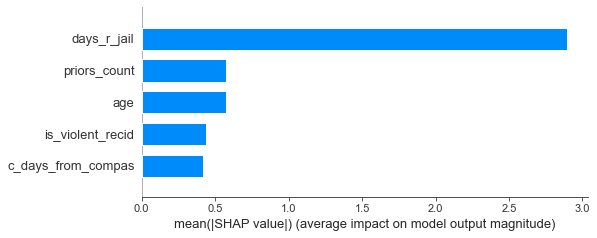

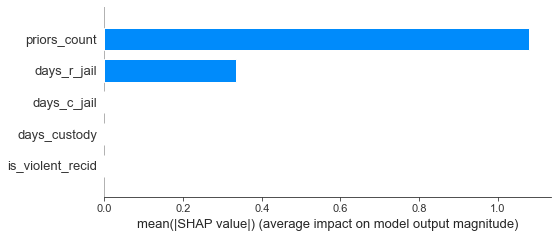

In [ ]:
# caucasican
shap.summary_plot(shap_values_caucasican, x_caucasican_train, plot_type="bar", max_display=5)
# native-american
shap.summary_plot(shap_values_native_american, x_native_american_train, plot_type="bar", max_display=5)

[08:26:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


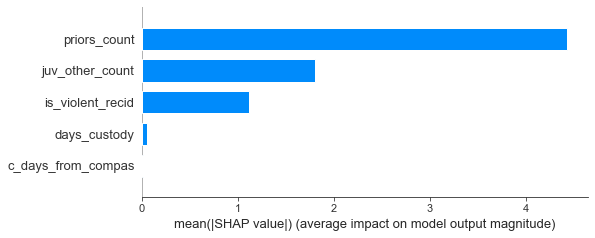

In [ ]:
# cocos native american
# Split data
x_cocos_native_american_train, x_cocos_native_american_test, y_cocos_native_american_train, y_cocos_native_american_test = model_selection.train_test_split(df_cocos_native_americans.drop(["is_recid"], axis=1), df_cocos_native_americans["is_recid"], random_state=0)
# Model
m_cocos_native_american = XGBClassifier().fit(x_cocos_native_american_train, y_cocos_native_american_train)
explainer_cocos_native_american = shap.Explainer(m_cocos_native_american)
shap_values_cocos_native_american = explainer_cocos_native_american(x_cocos_native_american_test)
# shap.plots.beeswarm(shap_values_cocos_native_american, max_display=10)
shap.summary_plot(shap_values_cocos_native_american, x_cocos_native_american_train, plot_type="bar", max_display=5)


## Uno y hago SHAP

In [ ]:
df_caucasican_native_american = pd.concat([df_race_caucasican, df_cocos_native_americans])
print(f"New tam {len(df_caucasican_native_american)}")

New tam 4898


[08:29:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


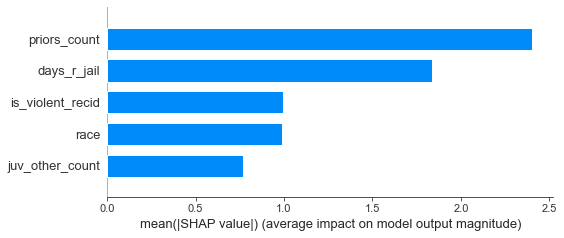

In [ ]:
# cocos final
# Split data
x_cocos_final_train, x_cocos_final_test, y_cocos_final_train, y_cocos_final_test = model_selection.train_test_split(df_caucasican_native_american.drop(["is_recid"], axis=1), df_caucasican_native_american["is_recid"], random_state=0)
# Model
m_cocos_final = XGBClassifier().fit(x_cocos_final_train, y_cocos_final_train)
explainer_cocos_final = shap.Explainer(m_cocos_final)
shap_values_cocos_final = explainer_cocos_final(x_cocos_final_test)
# shap.plots.beeswarm(shap_values_cocos_final, max_display=10)
shap.summary_plot(shap_values_cocos_final, x_cocos_final_train, plot_type="bar", max_display=5)

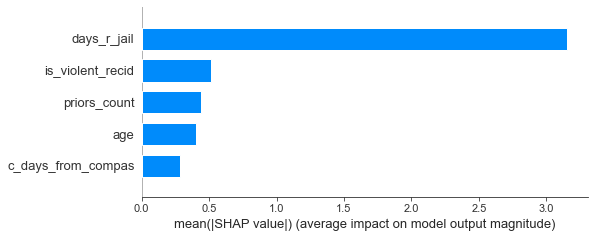

In [ ]:
# Inicial con todas las clases
shap.summary_plot(shap_values_1, x1_train, plot_type="bar", max_display=5)

## Con One-Hot encoding

**TODO**

# Conclusions

1. Problemas con el balanceo de datos: cantidad insuficiente en algunas clases
2. Tras hacer nuestro balanceo propuesto la desigualdad se ha reducido a aproximadamente la mitad.


El **problema** es la falta de datos en algunos dominios. La **propuesta** es una técnica de aumentado en función de las correlaciones para aportar sentido al aumentado y reducir la injusticia (Ethical AI). Además, **XAI** ha sido utilizado para apreciar como tras el aumentado de datos los pesos tienen más sentido.

## Future work

1. Observar la frecuencia de las muestras para generar nuevos datos, no sólo las correlaciones. -> YA SE ESTÁ HACIENDO SI NO SE QUITAN LOS DUPLICADOS AL SACAR LOS ÍNDICES
2. Validar con otro dataset midiendo el accuracy antes y después de la aplicación de COCOS.
3. Hacer librería COCOS para su uso (tipo SMOTE).
4. ¿Sería la "semilla"? Es decir, que en base a este artículo salga uno más grande con la prueba de todo y lo comentado aquí.
5. Podría haber incoherencias, es encesario revisar con conocimiento de dominio. -> pasar lista de condiciones por parámetro y si no cumple todas borrar la fila; también pasar el max it.